## <font color='darkblue'>Thực hành Huấn luyện mạng trí tuệ nhân tạo:
Trong bài này, chúng ta sẽ thực hành: 
- (i) tiền xử lý dữ liệu
- (ii) huấn luyện Neural Net

Bộ dữ liệu được sử dụng là bộ [Kaggle Titanic](https://www.kaggle.com/c/titanic); trong đó, đầu vào là thông tin của hành khách trên tàu Titanic (bạn xem chi tiết trong file `description.txt` đính kèm), đầu ra là một trong hai lớp sống/chết (1 | 0). Mình có đính kèm các file dữ liệu: `train.csv` - tập huấn luyện, `val.csv` - tập validation, `test.csv` - tập kiểm tra (chỉ có đầu vào); thật ra, Kaggle chỉ cung cấp hai file là `train.csv` và `test.csv`, mình đã tách file `train.csv` của Kaggle ra hai file là `train.csv` (80%) và `val.csv` (20%).

### <font color='blue'>Import</font>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy, re, time
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from tqdm.notebook import tqdm
#import cPickle
# You can also import other things ...

### <font color='blue'>Đọc dữ liệu tập huấn luyện và tập validation vào data frame

In [2]:
train_df = pd.read_csv('./sample_datas/titanic/train.csv', index_col=0)
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 11 columns):
Survived    712 non-null int64
Pclass      712 non-null int64
Name        712 non-null object
Sex         712 non-null object
Age         574 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Ticket      712 non-null object
Fare        712 non-null float64
Cabin       160 non-null object
Embarked    711 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q
32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C


In [3]:
val_df = pd.read_csv('./sample_datas/titanic/val.csv', index_col=0)
val_df.info()
val_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 529 to 685
Data columns (total 11 columns):
Survived    179 non-null int64
Pclass      179 non-null int64
Name        179 non-null object
Sex         179 non-null object
Age         140 non-null float64
SibSp       179 non-null int64
Parch       179 non-null int64
Ticket      179 non-null object
Fare        179 non-null float64
Cabin       44 non-null object
Embarked    178 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 16.8+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C
473,1,2,"West, Mrs. Edwy Arthur (Ada Mary Worth)",female,33.0,1,2,C.A. 34651,27.7500,NaN,S
432,1,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.1000,NaN,S
170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
676,0,3,"Edvardsson, Mr. Gustaf Hjalmar",male,18.0,0,0,349912,7.7750,NaN,S
740,0,3,"Nankoff, Mr. Minko",male,NaN,0,0,349218,7.8958,NaN,S
258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,B77,S
595,0,2,"Chapman, Mr. John Henry",male,37.0,1,0,SC/AH 29037,26.0000,NaN,S
831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.0,1,0,2659,14.4542,NaN,C


### <font color='blue'>Tiền xử lý

#### **Tiền xử lý tập huấn luyện**

In [4]:
train_input_df = train_df.iloc[:, 1:]
train_output_df = train_df.Survived

##### Xây dựng `train_X` từ `train_input_df`

(`train_X` là mảng numpy chứa các véc-tơ đầu vào mà có thể đưa trực tiếp vào mô hình học như ở các bài tập trước.)

Đầu tiên, ta sẽ tiến hành: 
- Bỏ cột `Cabin` vì cột này có nhiều giá thiếu (552/712).
- Bỏ cột `Ticket` vì cột này có giá trị không phải dạng số, sẽ cần phải tốn sức để chuyển sang dạng số , vì nó có quá nhiều định dạng và rất cần rất nhiều công sức và thời gian để có thể hiểu được các kí hiệu trên đó có nghĩa gì.

**Lưu ý** :

khi bỏ 2 cột `Cabin` và `Ticket` đi thì rất có thể sẽ làm mất thông tin để dự đoán `sống`|`chết`. Vì có khả năng đây là dữ liệu quan trọng liên quan đến vị trí nghỉ ngơi cụ thể trong từng khoang.


In [5]:
dropped_cols = ['Ticket', 'Cabin']
train_input_df.drop(dropped_cols, axis=1, inplace=True)
train_input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 8 columns):
Pclass      712 non-null int64
Name        712 non-null object
Sex         712 non-null object
Age         574 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Fare        712 non-null float64
Embarked    711 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 50.1+ KB


Kế đến, ta sẽ xử lý các giá trị thiếu ở cột `Age` và cột `Embarked`. Ở đây, ta xử lý đơn giản là điền giá trị mean (giá trị trung bình) vào các giá trị thiếu ở cột `Age`, và điền giá trị mode (giá trị xuất hiện nhiều nhất) vào các giá trị thiếu ở cột `Embarked`. *Lưu ý là, khi điền các giá trị thiếu ở tập validation/test, ta sẽ sử dụng các giá trị mean/mode được tính từ tập huấn luyện*. Trong thực tế,  ta thường sẽ không biết ở thời điểm test biến đầu vào nào sẽ thiếu giá trị; do đó, ta có thể làm một cách tổng quát như sau: với biến đầu vào có giá trị số, ta sẽ điền giá trị mean; ngược lại, điền giá trị mode. Dưới đây, hàm `compute_mean_mode` sẽ tính từ tập huấn luyện giá trị mean/mode của *tất cả* các biến đầu vào; hàm `fill_missing_values` sẽ dùng các giá trị mean/mode này để điền giá trị thiếu cho một tập dữ liệu nào đó (tập huấn luyện/validation/kiểm tra).

In [6]:
names = train_input_df["Name"].to_list()
len(names)

712

In [7]:
apellation = set([name.split(',')[1].split('.')[0] for name in names])
apellation = list(apellation)
apellation

[' Col',
 ' Mr',
 ' Jonkheer',
 ' Ms',
 ' Miss',
 ' Capt',
 ' Don',
 ' Mrs',
 ' Rev',
 ' Lady',
 ' Dr',
 ' the Countess',
 ' Major',
 ' Mlle',
 ' Master',
 ' Mme']

In [8]:
def preprocessing_Name(input_df):
    index = input_df.index.values.tolist()
    vector = []
    for key in apellation:
        tmp = list([])
        for i in index:
            apell = input_df.loc[i]["Name"].split(',')[1].split('.')[0]
            if(apell == key):
                tmp.append(1.0)
            else:
                tmp.append(0.0)
        vector.append(tmp)
        k = 6
    for i in range(len(vector)):
        input_df.insert(k+i, apellation[i], vector[i], allow_duplicates = True)
    input_df.drop('Name', axis=1, inplace=True)
    return input_df

In [9]:
def compute_mean_mode(train_input_df):
    '''
    Computes means for numeric input variables and modes for non-numeric ones.
    
    Parameters
    ----------
    train_input_df : data frame
        The data frame containing training inputs.
    
    Returns
    -------
    mean_mode_dict : dictionary, len = # input variables (# columns) of train_input_df
        mean_mode_dict[<column_name>] = mean/mode of this column.
    '''
    dic = {}
    for column in train_input_df:
        num = 0
        for i in range(7000):
            try:
                a = train_input_df.loc[i][column]
                num = i
                break
            except:
                next
        if (isinstance(train_input_df.loc[num][column], str)):
            if(len(train_input_df[column].mode()) > 0):
                dic[column] = str(train_input_df[column].mode()[0])
            else:
                dic[column] = ''
        else:
            dic[column] = train_input_df[column].mean()
    return dic

In [10]:
mean_mode_dict = compute_mean_mode(train_input_df)
mean_mode_dict

{'Pclass': 2.3230337078651684,
 'Name': 'Abbott, Mr. Rossmore Edward',
 'Sex': 'male',
 'Age': 29.488815331010457,
 'SibSp': 0.5140449438202247,
 'Parch': 0.37359550561797755,
 'Fare': 32.18301095505614,
 'Embarked': 'S'}

In [11]:
def fill_missing_values(input_df, mean_mode_dict):
    '''
    Fills missing values for ALL columns of `input_df` using `mean_mode_dict`.
    
    Parameters
    ----------
    input_df : data frame
        The data frame containing inputs.
    mean_mode_dict : dictionary
        mean_mode_dict[<column_name>] = mean/mode of this column (estimated from the training set).
    
    Returns
    -------
    filled_input_df : data frame
        The data frame containing inputs after filling missing values.
    '''
    for column in input_df:
        df = input_df[pd.isnull(input_df).any(axis=1)]
        index = df.index.to_numpy()
        for i in index:
            if(pd.isnull(input_df.loc[i, column])):
                input_df.loc[i, column] = mean_mode_dict[column]
    return input_df

In [12]:
# Before filling
missing_age_mask = train_input_df.Age.isnull()
missing_embarked_mask = train_input_df.Embarked.isnull()
print(train_input_df.Age[missing_age_mask].head())
print()
print(train_input_df.Embarked[missing_embarked_mask].head())

PassengerId
496   NaN
649   NaN
32    NaN
299   NaN
368   NaN
Name: Age, dtype: float64

PassengerId
62    NaN
Name: Embarked, dtype: object


In [13]:
# Fill and check the result
train_input_df = fill_missing_values(train_input_df, mean_mode_dict)
print(train_input_df.Age[missing_age_mask].head())
print()
print(train_input_df.Embarked[missing_embarked_mask].head())
print()
train_input_df.info()

PassengerId
496    29.488815
649    29.488815
32     29.488815
299    29.488815
368    29.488815
Name: Age, dtype: float64

PassengerId
62    S
Name: Embarked, dtype: object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 8 columns):
Pclass      712 non-null int64
Name        712 non-null object
Sex         712 non-null object
Age         712 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Fare        712 non-null float64
Embarked    712 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 70.1+ KB


Đến đây, ta đã bỏ các cột `Name`, `Ticket`, `Cabin`; và điền giá trị thiếu cho cột `Age`, `Embarked`. Kế đến, ta sẽ chuyển các cột có giá trị không phải dạng số (`Sex` và `Embarked`) sang dạng số. Vì `Sex` và `Embarked` là các biến có giá trị rời-rạc và không-có-thứ-tự nên ta có thể chuyển sang dạng "one-hot" (và bỏ cột cuối). Vd:

```
Sex    --> Female | Male
------     --------------
female --> 1      | 0
male   --> 0      | 1
female --> 1      | 0
```
và ta có thể bỏ cột `Male` đi.

In [14]:
def process_categorical_cols(input_df):
    '''
    Converts `Sex` column and `Embarked` column to one-hot forms.
    
    Parameters
    ----------
    input_df : data frame
        The data frame containing inputs.
    
    Returns
    -------
    numeric_input_df : data frame
        The data frame containing inputs after converting.
    '''
    sex_tag = ['female', 'male']
    Embarked_tag = ['C','Q','S']
    index = input_df.index.to_numpy()
    value_sex = []
    value_C = []
    value_Q = []
    
    print(len(input_df))
    
    try:
        for i in range(len(index)):
            if(input_df.loc[int(index[i])]['Sex'] == sex_tag[0]):
                value_sex.append(1.0)
            else:
                value_sex.append(0.0)
            if(input_df.loc[int(index[i])]['Embarked'] == Embarked_tag[0]):
                value_C.append(1.0)
            else:
                value_C.append(0.0)
            if(input_df.loc[int(index[i])]['Embarked'] == Embarked_tag[1]):
                value_Q.append(1.0)
            else:
                value_Q.append(0.0)
    
        input_df.insert(6, 'female', value_sex, allow_duplicates = True)
        input_df.insert(7, 'C', value_C, allow_duplicates = True)
        input_df.insert(8, 'Q', value_Q, allow_duplicates = True)
        input_df.drop('Sex', axis=1, inplace=True)
        input_df.drop('Embarked', axis=1, inplace=True)
    except:
        return input_df
    return input_df

In [15]:
train_input_df = process_categorical_cols(train_input_df)
train_input_df.info()

712
<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 9 columns):
Pclass    712 non-null int64
Name      712 non-null object
Age       712 non-null float64
SibSp     712 non-null int64
Parch     712 non-null int64
female    712 non-null float64
C         712 non-null float64
Q         712 non-null float64
Fare      712 non-null float64
dtypes: float64(5), int64(3), object(1)
memory usage: 75.6+ KB


In [16]:
train_input_df = preprocessing_Name(train_input_df)
train_input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 496 to 153
Data columns (total 24 columns):
Pclass           712 non-null int64
Age              712 non-null float64
SibSp            712 non-null int64
Parch            712 non-null int64
female           712 non-null float64
 Col             712 non-null float64
 Mr              712 non-null float64
 Jonkheer        712 non-null float64
 Ms              712 non-null float64
 Miss            712 non-null float64
 Capt            712 non-null float64
 Don             712 non-null float64
 Mrs             712 non-null float64
 Rev             712 non-null float64
 Lady            712 non-null float64
 Dr              712 non-null float64
 the Countess    712 non-null float64
 Major           712 non-null float64
 Mlle            712 non-null float64
 Master          712 non-null float64
 Mme             712 non-null float64
C                712 non-null float64
Q                712 non-null float64
Fare             712 non-

Cuối cùng, ta sẽ xây dựng `train_X`. Để giúp Gradient Descent hội tụ nhanh hơn, ta sẽ chuẩn hóa để các cột của `train_X` có mean bằng 0 và có độ lệch chuẩn bằng 1. *Lưu ý là, khi chuẩn hóa `val_X`/`test_X`, ta sẽ dùng mean và độ lệch chuẩn được ước lượng từ tập huấn luyện.*

In [17]:
train_X = train_input_df.values
print(train_X.shape)

(712, 24)


In [18]:
# compute `X_mean` and `X_std`
X_mean = train_X.mean(axis=0)
X_std = train_X.std(axis=0)

In [19]:
print(X_mean)
print(X_std)

[2.32303371e+00 2.94888153e+01 5.14044944e-01 3.73595506e-01
 3.49719101e-01 2.80898876e-03 5.80056180e-01 1.40449438e-03
 1.40449438e-03 2.12078652e-01 1.40449438e-03 1.40449438e-03
 1.27808989e-01 8.42696629e-03 1.40449438e-03 7.02247191e-03
 1.40449438e-03 2.80898876e-03 2.80898876e-03 4.63483146e-02
 1.40449438e-03 1.79775281e-01 8.42696629e-02 3.21830110e+01]
[8.34392606e-01 1.31205457e+01 1.07438220e+00 8.00827868e-01
 4.76881171e-01 5.29254036e-02 4.93549398e-01 3.74502574e-02
 3.74502574e-02 4.08780255e-01 3.74502574e-02 3.74502574e-02
 3.33877000e-01 9.14108994e-02 3.74502574e-02 8.35054298e-02
 3.74502574e-02 5.29254036e-02 5.29254036e-02 2.10238313e-01
 3.74502574e-02 3.84000168e-01 2.77791805e-01 5.22947658e+01]


In [20]:
# normalize train_X using X_mean and X_std
train_X = (train_X - X_mean) / X_std

In [21]:
print(train_X.mean(axis=0))
print(train_X.std(axis=0))

[ 2.09570189e-16 -4.98976640e-18  1.24744160e-18 -4.24130144e-17
  6.48669632e-17 -9.97953281e-18  3.99181312e-17 -2.49488320e-18
  2.49488320e-18  8.60734704e-17  2.49488320e-18  2.49488320e-18
 -3.49283648e-17 -7.48464960e-18  2.49488320e-18 -9.97953281e-18
  0.00000000e+00 -9.97953281e-18  0.00000000e+00 -2.49488320e-18
 -4.98976640e-18  2.49488320e-17  7.48464960e-18 -5.48874304e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


**1.2. Xây dựng `train_Y` từ `train_output_df`**

(`train_Y` là mảng numpy chứa các đầu ra đúng mà có thể đưa trực tiếp vào mô hình học như ở các bài tập trước.)

In [22]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

train_Y = train_output_df.values.reshape(-1, 1)
enc.fit(train_Y)

train_Y = enc.transform(train_Y).toarray()
print(train_Y.shape)

(712, 2)


**2. Tiền xử lý tập validation**

In [23]:
val_input_df = val_df.iloc[:, 1:]
val_output_df = val_df.Survived
len(val_input_df)

179

**2.1. Xây dựng `val_X` từ `val_input_df`**

Cách xây dựng `test_X` từ `test_input_df` sẽ *giống hệt* cách xây dựng `val_X` từ `val_input_df`. Do đó, ta sẽ viết phần xử lý này vào một hàm để lúc sau có thể dùng lại cho tập kiểm tra.

In [24]:
def process_new_input_df(new_input_df, dropped_cols, mean_mode_dict, X_mean, X_std):
    '''
    Builds `new_X` from `new_input_df`:
    1. Drop columns using `dropped_cols` (`dropped_cols` is the list containing names of dropped columns)
    2. Fill missing values using `mean_mode_dict` (use `fill_missing_values` function)
    3. Convert categorial columns to one-hot (use `process_categorical_cols` function)
    4. Subtract by `X_mean` and divide by `X_std`
    5. Add `x_0` column
    
    Parameters
    ----------
    I'm lazy now ...
    
    Returns
    -------
    new_X : numpy array
        The matrix of input vectors.
    '''
    new_input_df = new_input_df.drop(dropped_cols, axis=1)
    new_input_df = fill_missing_values(new_input_df, mean_mode_dict)
    new_input_df = process_categorical_cols(new_input_df)
    new_input_df = preprocessing_Name(new_input_df)
    print(new_input_df.info())
    new_X = new_input_df.values
    new_X = (new_X - X_mean)/X_std
#     new_X = np.hstack([np.ones((len(new_X), 1)), new_X])
    return new_X

In [25]:
val_X = process_new_input_df(val_input_df, dropped_cols, mean_mode_dict, X_mean, X_std)

179
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 529 to 685
Data columns (total 24 columns):
Pclass           179 non-null int64
Age              179 non-null float64
SibSp            179 non-null int64
Parch            179 non-null int64
female           179 non-null float64
 Col             179 non-null float64
 Mr              179 non-null float64
 Jonkheer        179 non-null float64
 Ms              179 non-null float64
 Miss            179 non-null float64
 Capt            179 non-null float64
 Don             179 non-null float64
 Mrs             179 non-null float64
 Rev             179 non-null float64
 Lady            179 non-null float64
 Dr              179 non-null float64
 the Countess    179 non-null float64
 Major           179 non-null float64
 Mlle            179 non-null float64
 Master          179 non-null float64
 Mme             179 non-null float64
C                179 non-null float64
Q                179 non-null float64
Fare             179 

**2.2. Xây dựng `val_Y` từ `val_output_df`**

In [26]:
val_Y = val_output_df.values.reshape(-1, 1)
val_Y.shape

(179, 1)

### <font color='blue'>Huấn luyện

In [27]:
from NeuralNet.Layers import *
from NeuralNet.Neuralnet import *
from NeuralNet.Optimizers import *

In [28]:
EPOCHS = 50
optimizer = Adam(0.0001)
loss_func = BinaryCrossEntropy()
archs = [
    Input(),
    Dense(num_neurons=1024, weight_init="glorot_normal", use_bias=False),
    Activation(activation="swish"),
    Dropout(keep_prob=0.5),
    Dense(num_neurons=512, weight_init="glorot_normal"),
    Activation(activation="swish"),
    Dropout(keep_prob=0.5),
    Dense(num_neurons=128, weight_init="glorot_normal", use_bias=False),
    Activation(activation="sigmoid"),
    Dense(num_neurons=2, weight_init="glorot_normal"),
    Activation(activation="softmax"),
]

val_set = (val_X, enc.transform(val_Y).toarray())

model = Model(optimizer=optimizer, layers=archs, loss_func=loss_func)
train_losses, val_losses, train_accs, val_accs = model.fit(train_X, train_Y, val_set, batch_size=16, epochs=EPOCHS)

import pickle
with open("./weights/titanic_ann.pkl", "wb") as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

Epoch 1 - Loss: 0.66119: 100%|██████████| 45/45 [00:02<00:00, 15.80it/s]
Loss at epoch 1: 0.66119 - Train accuracy: 0.63343 - Validation loss: 0.68845 - accuracy: 0.54749
Epoch 2 - Loss: 0.60383: 100%|██████████| 45/45 [00:02<00:00, 16.01it/s]
Loss at epoch 2: 0.60383 - Train accuracy: 0.66292 - Validation loss: 0.60430 - accuracy: 0.58659
Epoch 3 - Loss: 0.53961: 100%|██████████| 45/45 [00:03<00:00, 14.35it/s]
Loss at epoch 3: 0.53961 - Train accuracy: 0.79775 - Validation loss: 0.51423 - accuracy: 0.77654
Epoch 4 - Loss: 0.47884: 100%|██████████| 45/45 [00:02<00:00, 15.35it/s]
Loss at epoch 4: 0.47884 - Train accuracy: 0.79073 - Validation loss: 0.45745 - accuracy: 0.81006
Epoch 5 - Loss: 0.45246: 100%|██████████| 45/45 [00:03<00:00, 14.71it/s]
Loss at epoch 5: 0.45246 - Train accuracy: 0.79635 - Validation loss: 0.42737 - accuracy: 0.81564
Epoch 6 - Loss: 0.43583: 100%|██████████| 45/45 [00:02<00:00, 18.25it/s]
Loss at epoch 6: 0.43583 - Train accuracy: 0.80899 - Validation loss: 0.

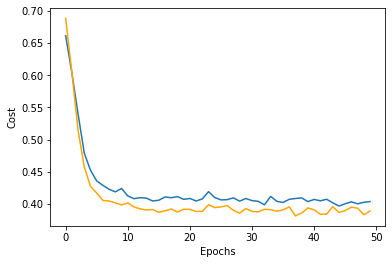

In [39]:
import matplotlib.pyplot as plt
plt.plot(range(EPOCHS), train_losses, label='training')
plt.plot(range(EPOCHS), val_losses, label='validation', color='orange')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

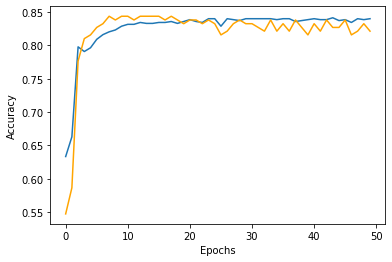

In [40]:
plt.plot(range(EPOCHS), train_accs, label='training')
plt.plot(range(EPOCHS), val_accs, label='validation', color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [33]:
with open("./weights/titanic_ann.pkl", "rb") as f:
            model = pickle.load(f)
pred = model.predict(val_X)
# val_Y = enc.inverse_transform(val_Y).reshape(val_Y.shape[0])
print("Accuracy:", len(pred[val_Y.reshape(val_Y.shape[0]) == pred]) / len(pred))
from sklearn.metrics import confusion_matrix
array = confusion_matrix(val_Y.reshape(val_Y.shape[0]), pred)

Accuracy: 0.8212290502793296


In [34]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

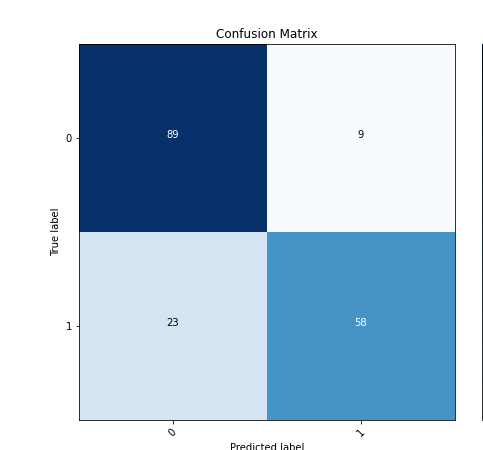

In [35]:
plot_confusion_matrix(cm           = array,
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")

## <font color='blue'>Kiểm tra (test)

**1. Đọc dữ liệu tập kiểm tra vào data frame `test_input_df`**

In [36]:
test_input_df = pd.read_csv('./sample_datas/titanic/test.csv', index_col=0)
test_input_df.info()
test_input_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**2. Xây dựng `test_X` từ `test_input_df`**

In [37]:
test_X = process_new_input_df(test_input_df, dropped_cols, mean_mode_dict, X_mean, X_std)

418
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 24 columns):
Pclass           418 non-null int64
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
female           418 non-null float64
 Col             418 non-null float64
 Mr              418 non-null float64
 Jonkheer        418 non-null float64
 Ms              418 non-null float64
 Miss            418 non-null float64
 Capt            418 non-null float64
 Don             418 non-null float64
 Mrs             418 non-null float64
 Rev             418 non-null float64
 Lady            418 non-null float64
 Dr              418 non-null float64
 the Countess    418 non-null float64
 Major           418 non-null float64
 Mlle            418 non-null float64
 Master          418 non-null float64
 Mme             418 non-null float64
C                418 non-null float64
Q                418 non-null float64
Fare             418

**3. Dự đoán nhãn lớp của test_X**

In [38]:
with open("./weights/titanic_ann.pkl", "rb") as f:
            nn = pickle.load(f)
        
# Predict
preds = nn.predict(test_X)
preds_df = pd.DataFrame(preds, index=test_input_df.index, columns=['Survived'])
preds_df.head()
preds_df.to_csv('predicts/titanic_ann_preds.csv')

*submit file `titanic_ann_preds.csv` lên [Kaggle](https://www.kaggle.com/c/titanic/submissions/attach), và ghi nhận lại độ chính xác.*

Kết quả cho single model MLP from Scratch: ```Your submission scored 0.80622```